In [ ]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller


In [ ]:
def select_lag_order(data, max_lag):
    best_aic = float('inf')
    best_bic = float('inf')
    best_lag = 0

    for lag in range(1, max_lag + 1):
        model = VAR(data)
        results = model.fit(lag)
        current_aic = results.aic
        current_bic = results.bic
        if current_aic < best_aic:
            best_aic = current_aic
            best_bic = current_bic
            best_lag = lag

    return best_lag, best_aic, best_bic

In [ ]:
# Get the data
# Define currency pairs
currency_pairs = ["EURUSD=X", "USDJPY=X"]

# Define the date range for the current year
start_date = "2023-01-02"
end_date = "2023-09-10"

# Fetch historical data
data = yf.download(currency_pairs, start=start_date, end=end_date)


[*********************100%%**********************]  2 of 2 completed


In [ ]:
df_price = data['Adj Close']

In [ ]:
date_range = pd.date_range(start=df_price.index.min(), end='2023-09-10', freq='D')

In [ ]:
df = pd.DataFrame(index=date_range)

In [ ]:
df_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 180 entries, 2023-01-02 to 2023-09-08
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   EURUSD=X  180 non-null    float64
 1   USDJPY=X  180 non-null    float64
dtypes: float64(2)
memory usage: 4.2 KB


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 252 entries, 2023-01-02 to 2023-09-10
Freq: D
Empty DataFrame


In [ ]:
df = df.merge(df_price,left_index=True, right_index=True,how='left')

In [ ]:
df.fillna(method='ffill',inplace=True)

Correlation:
0.15495880852649951


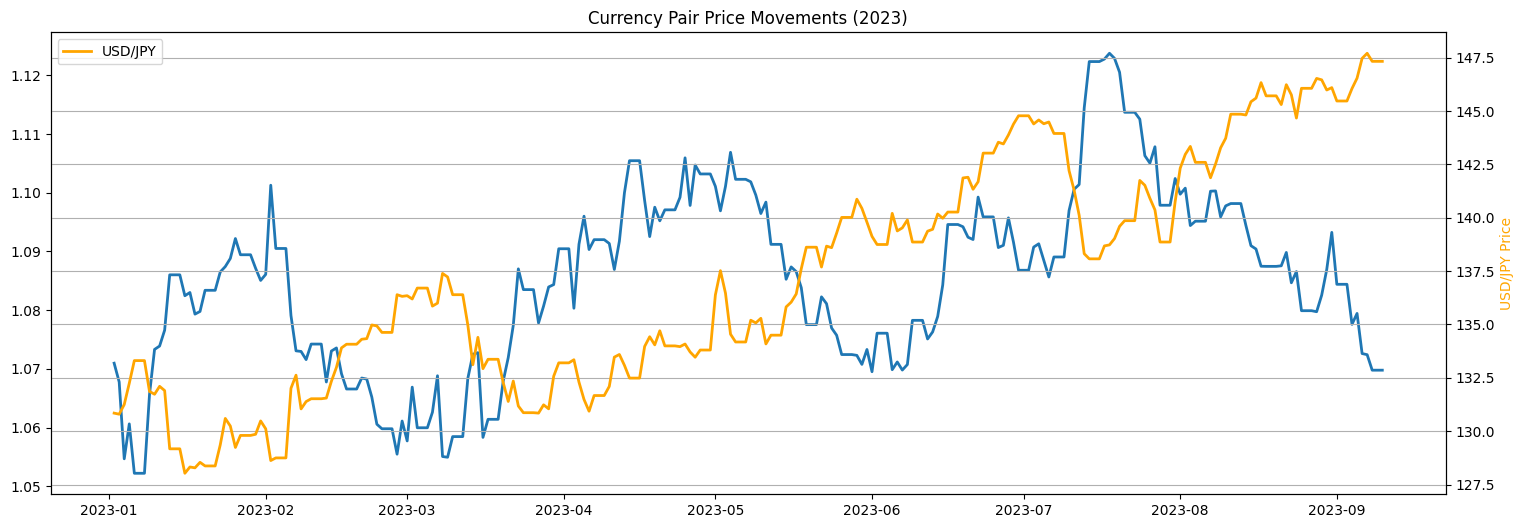

In [ ]:
# Calculate correlation
correlation = df['EURUSD=X'].corr(df['USDJPY=X'])

# Print the correlation
print("Correlation:")
print(correlation)

# Create a line chart to visualize the price movements
plt.figure(figsize=(18, 6))

# Plot EUR/USD
plt.plot(df.index, df['EURUSD=X'], label='EUR/USD', linewidth=2)

# Create a secondary y-axis for USD/JPY
plt.twinx()
plt.plot(df.index, df['USDJPY=X'], label='USD/JPY', color='orange', linewidth=2)

# Set chart title and labels
plt.title('Currency Pair Price Movements (2023)')
plt.xlabel('Date')
plt.ylabel('EUR/USD Price')
plt.ylabel('USD/JPY Price', color='orange')

# Add legends
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

*Stationary test with AdFuller* \
*Null hypothesis -> p-value > 0.05 - This implies that time-series is non-stationary.* \
*Alternative hypothesis -> p-value <=0.05 - This implies that time-series is stationary.*

In [ ]:
#Stationary test with AdFuller for EURUSD
print("Observations of Dickey-fuller test")
dftest = adfuller(df['EURUSD=X'],autolag='AIC')
print("p-value : ", dftest[1])

Observations of Dickey-fuller test
p-value :  0.16831347255056578


In [ ]:
#Stationary test with AdFuller for USDJPY
print("Observations of Dickey-fuller test")
dftest = adfuller(df['USDJPY=X'],autolag='AIC')
print("p-value : ", dftest[1])

Observations of Dickey-fuller test
p-value :  0.8167637835811822


*Weak evidence against the null hypothesis* \
*Fail to Reject the null hypothesis* \
*Data is not stationary*

In [ ]:
# Remove trend component with differencing
df['EURUSD=X Shifted'] = df['EURUSD=X'].shift(1)
df['USDJPY=X Shifted'] = df['USDJPY=X'].shift(1)

In [ ]:
# Drop the NA values
df.dropna(inplace=True)

In [ ]:
df['EURUSD Dif'] = df['EURUSD=X']-df['EURUSD=X Shifted']
df['USDJPY Dif'] = df['USDJPY=X']-df['USDJPY=X Shifted']

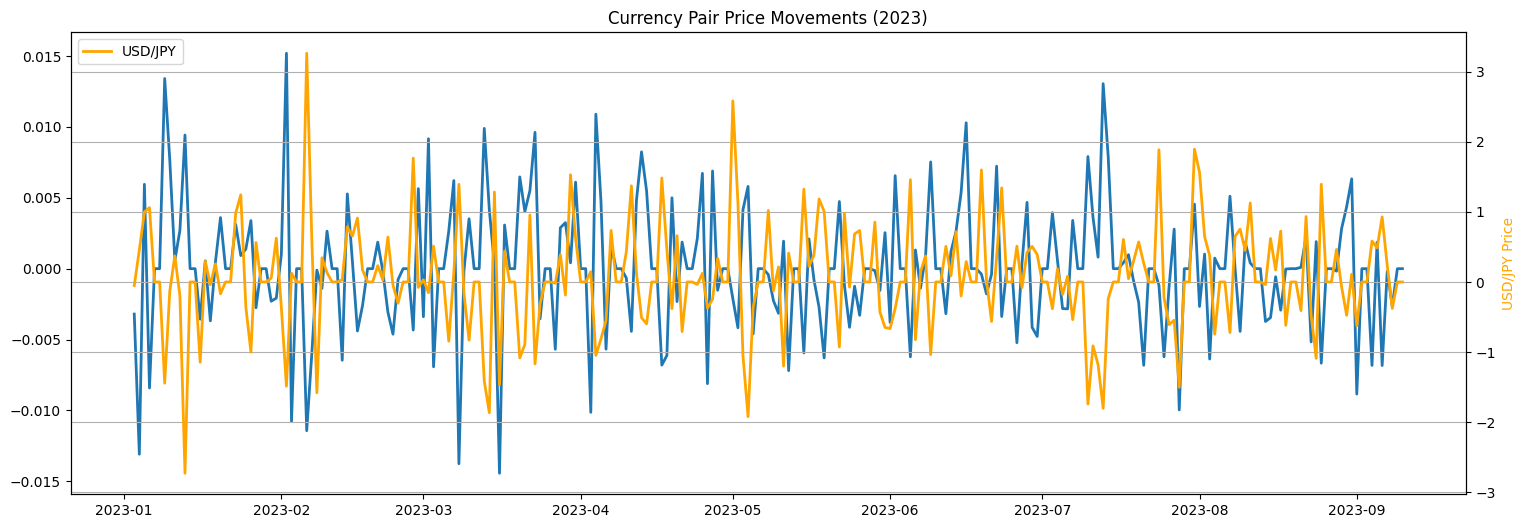

In [ ]:
# Create a line chart to visualize the price movements
plt.figure(figsize=(18, 6))

# Plot EUR/USD
plt.plot(df.index, df['EURUSD Dif'], label='EUR/USD', linewidth=2)

# Create a secondary y-axis for USD/JPY
plt.twinx()
plt.plot(df.index, df['USDJPY Dif'], label='USD/JPY', color='orange', linewidth=2)

# Set chart title and labels
plt.title('Currency Pair Price Movements (2023)')
plt.xlabel('Date')
plt.ylabel('EUR/USD Price', color='blue')
plt.ylabel('USD/JPY Price', color='orange')

# Add legends
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

*Strong evidence against the null hypothesis* \
*Reject the null hypothesis* \
*Data is stationary*

In [ ]:
#2nd Stationary test with AdFuller for EURUSD
print("Dickey-fuller test EUR/USD")
dftest = adfuller(df['EURUSD Dif'],autolag='AIC')
print("p-value : ", dftest[1])
print("Dickey-fuller USD/JPY")
dftest = adfuller(df['USDJPY Dif'],autolag='AIC')
print("p-value : ", dftest[1])

Dickey-fuller test EUR/USD
p-value :  1.483534777766705e-29
Dickey-fuller USD/JPY
p-value :  6.880792700556064e-14


In [ ]:
corr_EURUSD_USDJPY = df['EURUSD Dif'].corr(df['USDJPY Dif'])

# Print the correlation
print("Correlation:")
print(corr_EURUSD_USDJPY)

Correlation:
-0.4151462182638844


*Conclusion: EURUSD and USDJPY have negative correlation and they're going to be used in the trading system*

In [ ]:
train_data = df[['EURUSD Dif','USDJPY Dif']][:-7]

In [ ]:
test_data = df[['EURUSD Dif','USDJPY Dif']][-7:]

In [ ]:
selected_lag, best_aic, best_bic = select_lag_order(train_data, 10)
print(f"Selected lag order: {selected_lag}, AIC: {best_aic}, BIC: {best_bic}")

Selected lag order: 2, AIC: -11.597197836886417, BIC: -11.45302685646672


In [ ]:
train_data.columns

Index(['EURUSD Dif', 'USDJPY Dif'], dtype='object')

In [ ]:
model = VAR(train_data)
model_fit = model.fit(maxlags=7)

In [ ]:
forecast = model_fit.forecast(train_data.values[-model_fit.k_ar:],steps=7)

In [ ]:
forecast_df = pd.DataFrame(forecast,columns=train_data.columns)

In [ ]:
forecast_df.index = test_data.index

In [ ]:
forecast_df

,EURUSD Dif,USDJPY Dif
2023-09-04,-0.000953,0.312109
2023-09-05,0.001203,0.150230
2023-09-06,-0.000235,-0.012799
2023-09-07,-0.000216,0.290082
2023-09-08,0.001382,-0.092753
2023-09-09,0.000277,0.011589
2023-09-10,0.000214,0.073886


In [ ]:
test_data

,EURUSD=X,USDJPY=X,EURUSD=X Shifted,USDJPY=X Shifted,EURUSD Dif,USDJPY Dif
2023-09-04,1.077586,146.057007,1.084410,145.473007,-0.006824,0.584000
2023-09-05,1.079447,146.542999,1.077586,146.057007,0.001861,0.485992
2023-09-06,1.072616,147.470993,1.079447,146.542999,-0.006831,0.927994
2023-09-07,1.072420,147.709000,1.072616,147.470993,-0.000196,0.238007
2023-09-08,1.069782,147.330994,1.072420,147.709000,-0.002639,-0.378006
2023-09-09,1.069782,147.330994,1.069782,147.330994,0.000000,0.000000
2023-09-10,1.069782,147.330994,1.069782,147.330994,0.000000,0.000000
